In [10]:
# https://pytorch.org/vision/stable/index.html
import torch
import torchvision.datasets as dsets                # 데이터셋 모음
import torchvision.transforms as transforms         # 전처리 모음
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [11]:
torch.cuda.is_available()

True

In [12]:
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

In [13]:
# hyperparameters
training_epochs = 15
batch_size = 100

## 소프트맥스 회귀로 MNIST 데이터 분류

MNIST는 숫자 0부터 9까지의 이미지로 구성된 손글씨 데이터셋

총 60,000개의 훈련 데이터와 레이블, 총 10,000개의 테스트 데이터와 레이블로 구성

각 이미지는 28 * 28 픽셀의 이미지

In [14]:
# MNIST dataset
mnist_train = dsets.MNIST(root='dataset/MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='dataset/MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

drop_last는 배치크기를 충족하지 못한 마지막 배치를 버리는 속성

마지막 배치가 상대적으로 과대 평가되는 현상을 막을 수 있음

In [15]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size, # 배치 크기는 100 
                         shuffle=True,
                         drop_last=True)

In [16]:
# MNIST data image of shape 28 * 28 = 784
# GPU 사용시 .to('cuda') 사용할 필요가 있음, .to 는 어느 디바이스에서 연산을 수행할지 결정
linear = nn.Linear(784, 10, bias=True).to('cuda')

In [17]:
# 비용 함수와 옵티마이저 정의
# torch.nn.functional.cross_entropy() 와 같이 소프트맥스 함수를 포함함
criterion = nn.CrossEntropyLoss().to('cuda') # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [18]:
# 학습
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to('cuda')
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to('cuda')

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print(f'Epoch: {epoch+1:04d}, cost = {avg_cost:.9f}')


Epoch: 0001, cost = 0.533756435
Epoch: 0002, cost = 0.359071344
Epoch: 0003, cost = 0.330853909
Epoch: 0004, cost = 0.316269398
Epoch: 0005, cost = 0.306897253
Epoch: 0006, cost = 0.299754918
Epoch: 0007, cost = 0.295043975
Epoch: 0008, cost = 0.290703624
Epoch: 0009, cost = 0.287395418
Epoch: 0010, cost = 0.284370959
Epoch: 0011, cost = 0.281917334
Epoch: 0012, cost = 0.279720336
Epoch: 0013, cost = 0.277781814
Epoch: 0014, cost = 0.275830269
Epoch: 0015, cost = 0.274402380


Accuracy: 0.8837999701499939
Label:  4
Prediction:  4


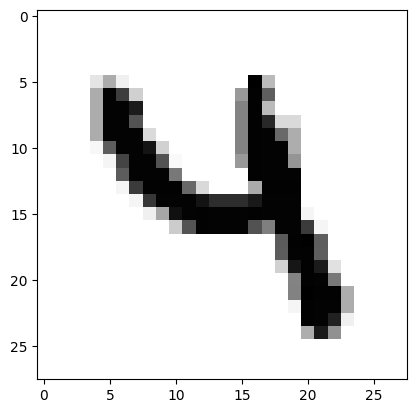

In [19]:
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to('cuda')
    Y_test = mnist_test.test_labels.to('cuda')

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to('cuda')
    Y_single_data = mnist_test.test_labels[r:r + 1].to('cuda')

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()